<div style='background-image: url("https://i.ibb.co/2t6jDtW/igte-tu-banner.png") ; padding: 0px ; background-size: 40% 130% ; background-repeat: no-repeat; border-radius: 5px ; height: 250px'>
<div style="position: absolute; top: 100px; left: 260px; border-radius: 10px; background: rgba(212, 212, 212, 0.6) ; width:600px; height: 150px">
<div style="position: relative; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; padding-top: 5px; padding-left: 130px ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%">Optimization I : HW-1</div>
            <div style="font-size: large ; padding-top: 20px ; padding-left: 135px ; color: rgba(0 , 0 , 0 , 0.6)">Bracketing, Sectioning and Line Search</div>
            <div style="font-size: small ; padding-top: 5px ; padding-left: 25px ; color: rgba(0 , 0 , 0 , 0.4)">18.10.2023 </div>
                    <div style="font-size: small ; padding-top: 0px ; padding-left: 25px ; color: rgba(0 , 0 , 0 , 0.4)">Group Nr. 05, Haris Felic ( 01609136 ), Student Student ( 01530104 ) </div>
        </div>
    </div>
</div>

## Task 1 ( 1D - problem ) :

| s | k | $f(a)$ | $f(b)$ | $f(b)-f(a)$ | $a$ | $b$ | $b-a$ | $\# function\;calls$ |
| :-: | :-: | :-: | :-: |:-: |:-: |:-: |:-: |:-: |
| 0.01 | 2 | -0.5834| -0.5834 | <img width=100/> 0.0000 | 0.3863| 0.3872 | 0.0009 | <img width=100/> 20
| 0.1 | 2 | -0.5834| -0.5834 | <img width=100/> 0.0000 | 0.3864| 0.3871 | 0.0007 | <img width=100/> 18
| 1 | 2 | -1.9887| -1.9887 | <img width=100/> 0.0000 | 1.4262| 1.4271 | 0.0008 | <img width=100/> 20
| 0.01 | 4 | -0.5834| -0.5834 | <img width=100/> 0.0000 | 0.3860| 0.3870 | 0.0009 | <img width=100/> 19
| 0.1 | 4 | -0.5834| -0.5834 | <img width=100/> 0.0000 | 0.3862| 0.3871 | 0.0010 | <img width=100/> 16
| 1 | 4 | -1.9887| -1.9887 | <img width=100/> 0.0000 | -1.4262| -1.4271 | 0.0009 | <img width=100/> 21

In [ ]:
from typing import Callable, List, Tuple
from dataclasses import dataclass
import numpy as np

import matplotlib.pyplot as plt
import test_functions as tf
from matplotlib import pyplot

############ Solution functions ################
# The function bodies in the following section #
# are to be edited. The function input params  #
# and return values along with the function    #
# name must not change as well as the imports  #
################################################

############ Global variables #################
rho: float = 0.61803398875
state: str = True
############ Helper functions #################
def bracketing(
        a: float,
        s: float,
        k: float,
        f: Callable,
        max_it: float = 10e3,
        ):
    b = a + s
    i = 1

    if f(a)>f(b):
        pass
    else:
        a,b = b,a
        s = -s
    c = b + s

    while state == True:
        # plt.figure(dpi=400)
        # plt.plot(interval, test_fun(interval), 'ko-', linewidth=0.5, markersize = 2)
        # plt.scatter(a, f(a), s=30, c='r', label='A', marker='^')  
        # plt.scatter(b, f(b), s=30, c='b', label='B', marker='^')  
        # plt.scatter(c, f(c), s=30, c='g', label='C', marker='^')  
        # plt.legend()
        # plt.title(f'Bracketing - Iteration {i}')
        
        i +=1
        if f(c) > f(b):
            break
        elif i > max_it:
            print("Max. iterations reached!")
            break
        else:
            a = b
            b = c
            s = s * k
            c = b + s
    return a,b,c,i


def sectioning(
        a: float,
        b: float,
        c: float,
        f: Callable,
        tol: float = 1e-3,
        max_it: float = 10e3,
        ):

    c_range = c - rho*(c-a)
    a_range = a + rho*(c-a)

    counter = 1

    while state == True:
        
        # plt.figure(dpi=400)
        # plt.plot(interval, test_fun(interval), 'ko-', linewidth=0.5, markersize = 2)
        # plt.scatter(a, f(a), s=30, c='r', label='A', marker='^')  
        # plt.scatter(c_range, f(c_range), s=60, c='b', label='B (c_range)', marker='*')  
        # plt.scatter(a_range, f(a_range), s=60, c='b', label='B (a_range)', marker='+')  
        # plt.scatter(c, f(c), s=30, c='g', label='C', marker='^')  
        # plt.legend()
        # plt.title(f'Sectioning - Counter {counter}')
        

        if f(c_range) < f(a_range):
            c = a_range
            a_range = c_range
            c_range = c - rho*(c-a)
        elif counter > max_it:
            print("Max. iterations reached!")
            break    
        else:
            a = c_range
            c_range = a_range
            a_range = a + rho*(c-a)

        if abs(a-c) < tol:
            print("\nThreshold reached")
            break
        counter += 1
    return a,c,counter
###############################################
########### Main solution function : ##########
def line_search(
    f: Callable,
    alpha0: float,
    x0: np.ndarray,
    g: np.ndarray,
    s: float = 10e-2,
    k: float = 2.0,
    eps: float = 1e-2,
) -> Tuple[float, float, int]:
    """[summary]

    Args:
        f (Callable): Function to perform the line search on.
        alpha0 (float): Initial step parameter.
        x0 (np.ndarray): Starting position.
        g (np.ndarray): Search direction.
        s (float, optional): Line search step scalar. Defaults to 10e-2.
        k (float, optional): Line search step expansion. Defaults to 2.0.
        eps (float, optional): Termination condition eps. Defaults to 1e-2.

    Returns:
        Tuple[float, float, int]: bracket left, bracket right, number of function calls
    """

    line_fun = lambda alpha: f(x0 + alpha*g)

    a, b, c, i_run = bracketing(alpha0,s,k,line_fun)
    
    a,c, counter = sectioning(a, b, c,line_fun)
    f_calls = i_run + counter
    

    return a,c, f_calls

test_fun = lambda x: np.sin(x) - np.sin(10/3*x)
interval = np.linspace(0,0.5)
a,b, f_calls = line_search(x0 = 0.0, alpha0 = 0, g = 1, s = 0.01, k = 2, f = test_fun)
print(f"s = 0.01, k = 2, f(a) = {test_fun(a):2.4f}, f(b) = {test_fun(b):2.4f}, a = {a:2.4f}, b = {b:2.4f}, b-a = {b-a:2.4f}, function calls = {f_calls} ")


a,b, f_calls = line_search(x0 = 0.0, alpha0 = 0, g = 1, s = 0.1, k = 2, f = test_fun)
print(f"s = 0.1, k = 2, f(a) = {test_fun(a):.4f}, f(b) = {test_fun(b):2.4f}, a = {a:2.4f}, b = {b:2.4f}, b-a = {b-a:2.4f}, function calls = {f_calls} ")



a,b, f_calls = line_search(x0 = 0.0, alpha0 = 0, g = 1, s = 1, k = 2, f = test_fun)
print(f"s = 1, k = 2, f(a) = {test_fun(a):2.4f}, f(b) = {test_fun(b):2.4f}, a = {a:2.4f}, b = {b:2.4f}, b-a = {b-a:2.4f}, function calls = {f_calls} ")


a,b, f_calls = line_search(x0 = 0.0, alpha0 = 0, g = 1, s = 0.01, k = 4, f = test_fun)
print(f"s = 0.01, k = 4, f(a) = {test_fun(a):2.4f}, f(b) = {test_fun(b):2.4f}, a = {a:2.4f}, b = {b:2.4f}, b-a = {b-a:2.4f}, function calls = {f_calls} ")


a,b, f_calls = line_search(x0 = 0.0, alpha0 = 0, g = 1, s = 0.1, k = 4, f = test_fun)
print(f"s = 0.1, k = 4, f(a) = {test_fun(a):2.4f}, f(b) = {test_fun(b):2.4f}, a = {a:2.4f}, b = {b:2.4f}, b-a = {b-a:2.4f}, function calls = {f_calls} ")





## Task 2 ( nD - problem ) :

Minimum found at point $\mathbf{x} = (0.61, 0.38)^T$ and $\alpha = 2.38$ and $f(\alpha) = 0.14$ 

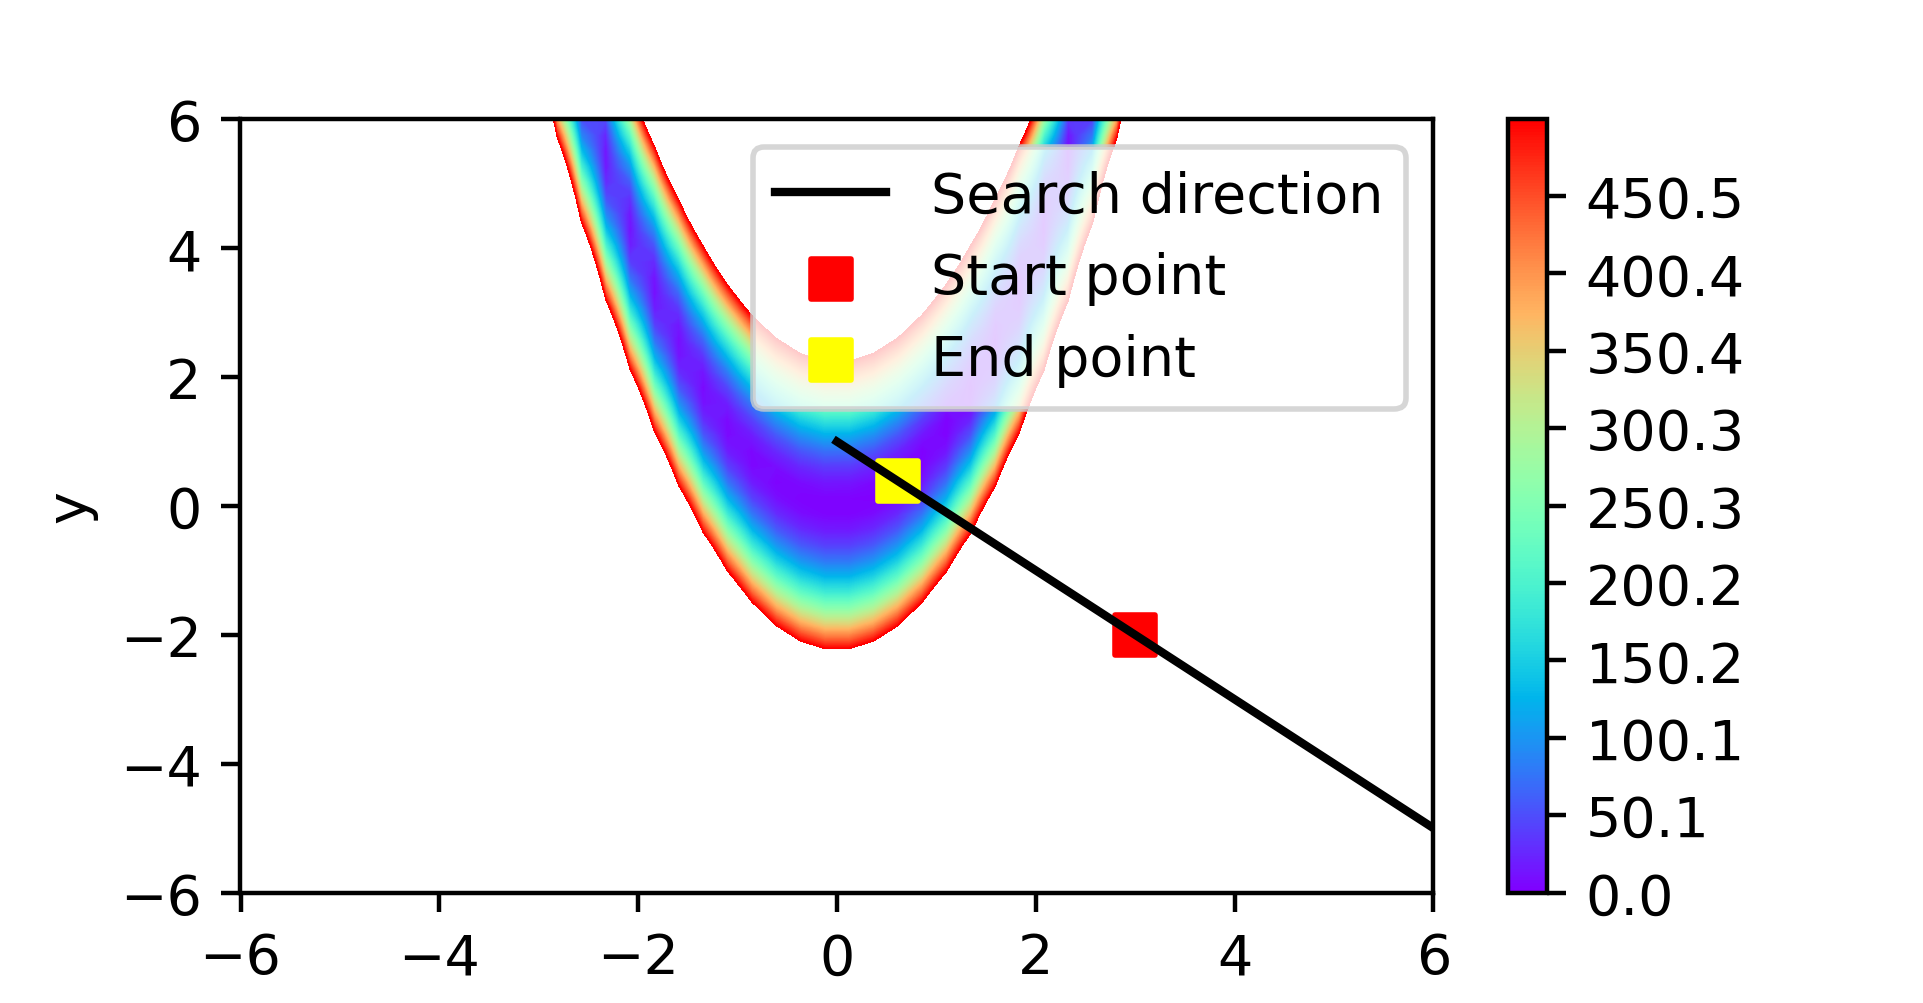

In [ ]:
# Get the 2D test function : 
f = tf.test_function(1)[0]
# (1) ... Rosenbrock function, (2) ... Himmelblau function, (3) ... Rastrigin function

# Define the starting point, search direction, and call line_search
x0 = np.array([[3, -2]])
g = np.array([[-1, 1]])

alpha0 = 0
a,b, f_calls = line_search(alpha0=alpha0, x0=x0, g=g, s=1, k=2, f = f)


# Take the mean value of the bounds as the optimal distance
α = 0.5*(a + b)

# Now I know the distance, but not the solution in the 2D parameter space! -->
# Starting point of the line search (if α0 is not 0)
X0 = x0 + alpha0*g

# Minimizer x*
Xs = x0 + α*g 
print('minimum found at α =', a, 'thus at point x* = ', Xs, 'with f(\alpha) = ', f(Xs))


fig, ax = plt.subplots(figsize=(8,6), dpi=400)
x = np.linspace(-6,6,50)
xx, yy = np.meshgrid(x,x)
zz = f(np.column_stack((xx.flatten(), yy.flatten())))
cf = ax.contourf(xx, yy, zz.reshape(xx.shape), levels=np.linspace(0, 500, 1000), cmap="rainbow")

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.colorbar(cf)


α_v = np.linspace(-3,3,50)
X = α_v[:,None]*g + x0
ax.plot(X[:,0],X[:,1],'black',label="Search direction")

ax.scatter(x0[0,0], x0[0,1],marker="s",label="Start point",s=50,color='red')
ax.scatter(Xs[0,0], Xs[0,1],marker="s",label="End point",s=50,color='yellow')
ax.legend()

plt.savefig("contour_plot.png", dpi=400)


yav = f(X)
fig = plt.figure(dpi = 400)
pyplot.plot(α_v,yav,'r',label="function values along search direction")
pyplot.scatter(α,f(x0+α*g),marker="s",label="minimum found",s=50)
pyplot.xlabel('α') 
pyplot.ylabel('objective function value f(α)')
pyplot.legend(); pyplot.grid()

plt.savefig("objectivefunction.png", dpi=400)

fig = plt.figure(figsize=((9,7)), dpi = 400)
ax = plt.axes(projection='3d')
ax.contour3D(xx,yy,zz.reshape(xx.shape),100,cmap="rainbow")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

ax.plot(X[:,0],X[:,1],0,'black',label="Search direction")
ax.scatter(x0[0,0], x0[0,1], 0,marker="s",label="Start point",s=50,color='red')
ax.scatter(Xs[0,0], Xs[0,1], 0, marker="s",label="End point",s=50,color='yellow')
ax.legend()

ax.view_init(60, 310)
plt.savefig("3Dplot.png", dpi=400)